In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# set the path to the project directory
# os.chdir('/Users/olarinoyem/Project/data_driven_vaccination/')

os.chdir("/Users/ajaoo/Desktop/Projects/data_driven_vaccination")

In [3]:
# Set up matplotlib
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
    
    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": [8, 6],  # Default figure size
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Automatic layout adjustments
    "figure.dpi": 600,  # High resolution figures for publication quality
    "savefig.dpi": 600,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures
    
    
    #title, xlabel and ylabel bold
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    
    
    # Axes aesthetics for clarity and precision
    "axes.labelsize": 12,
    "axes.titlesize": 18,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background
    "axes.grid": False,  # Enable grid for better readability
    "axes.spines.top": False,  # Disable top spine for aesthetic purposes
    "axes.spines.right": False,  # Disable right spine for aesthetic purposes
    "axes.formatter.limits": (0, 5),  # Threshold for scientific notation
    "axes.formatter.use_mathtext": True,  # Use mathtext for scientific notations
    "axes.formatter.useoffset": False,  # Disable offset on axes
    "axes.xmargin": 0,  # No margin around x-axis
    "axes.ymargin": 0,  # No margin around y-axis
    # Legend aesthetics
    "legend.fontsize": 12,
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning
    
    # Line aesthetics
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance
    
    # Tick aesthetics
    "xtick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "xtick.top": False,  # Disable top ticks for aesthetic purposes
    "ytick.labelsize": 12,
    "ytick.direction": "in",  # Ticks inside the plot
    "ytick.right": False,  # Disable right ticks for aesthetic purposes
    
    # Grid settings
    "grid.color": "grey",  # Grid color
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.linewidth": 0.5,  # Thin grid lines
    
    # Error bar aesthetics
    "errorbar.capsize": 4,  # Error bar cap length
    
    # Layout settings
    "figure.subplot.wspace": 0.4,  # Adjust horizontal spacing between subplots
    "figure.subplot.hspace": 0.4,  # Adjust vertical spacing between subplots
    
    # Latex and color map settings
    "image.cmap": "viridis",  # Preferred color map for images
    "text.latex.preamble": r"\usepackage{amsmath}",  # Latex preamble for math expressions
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load the data and check the first few rows
df = pd.read_csv("data/processed/england_data.csv")
df.head()

,date,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,hospitalCases,newAdmissions,population,covidOccupiedMVBeds,cumAdmissions
0,2020-04-01,3989.0,694.0,35571.0,4730.0,15544.0,4382,56171302,0.0,31201
1,2020-04-02,3895.0,725.0,39466.0,5455.0,15364.0,3937,56171302,1878.0,35138
2,2020-04-03,3878.0,737.0,43344.0,6192.0,18158.0,3388,56171302,2261.0,38526
3,2020-04-04,3260.0,828.0,46604.0,7020.0,20489.0,3446,56171302,2458.0,41972
4,2020-04-05,2994.0,823.0,49598.0,7843.0,22051.0,3446,56171302,2650.0,45418


In [5]:
params = {
    "alpha": 0.1,  # Rate of transmission from the infected not requiring hospitalization
    "sigma": 0.1,  # Rate of transmission from the infected requiring hospitalization
    "beta": 0.17,  # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,  # Recovery rate
    "theta": 0.001,  # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,  # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,  # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,  # Recovery rate for critical
    "xi": 0.005,  # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [params["N"] - 1, 1, 0, 0, 0, 0]

In [6]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


# def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
#     """
#     Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

#     Args:
#         df (pd.DataFrame): The input DataFrame with time series data.
#         train_size (float): Proportion of the dataset to allocate to training.
#         val_size (float): Proportion of the dataset to allocate to validation.
#         test_size (float): Proportion of the dataset to allocate to testing.

#     Returns:
#         tuple: Three DataFrames corresponding to the training, validation, and test sets.
#     """
#     if not np.isclose(train_size + val_size + test_size, 1.0):
#         raise ValueError("train_size, val_size, and test_size should sum to 1.")

#     n = len(df)
#     train_end = int(n * train_size)
#     val_end = train_end + int(n * val_size)

#     train_data = df.iloc[:train_end]
#     val_data = df.iloc[train_end:val_end]
#     test_data = df.iloc[val_end:]

#     return train_data, val_data, test_data

In [7]:
data = load_and_preprocess_data(
    "data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-01",
)

data.head()

,date,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,hospitalCases,newAdmissions,population,covidOccupiedMVBeds,cumAdmissions,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,3989.0,694.000000,35571.000000,4730.00,15544.000000,4382,56171302,0.000000,31201,0,0.0,30841.000000,56135731.0
1,2020-04-02,3895.0,709.500000,37518.500000,5092.50,15454.000000,3937,56171302,939.000000,35138,1,0.0,32426.000000,56131836.0
2,2020-04-03,3878.0,718.666667,39460.333333,5459.00,16355.333333,3388,56171302,1379.666667,38526,2,0.0,34001.333333,56127958.0
3,2020-04-04,3260.0,746.000000,41246.250000,5849.25,17388.750000,3446,56171302,1649.250000,41972,3,0.0,35397.000000,56124698.0
4,2020-04-05,2994.0,761.400000,42916.600000,6248.00,18321.200000,3446,56171302,1849.400000,45418,4,0.0,36668.600000,56121704.0


In [8]:
# select from the beginning of the pandemic in the data to the end of 2021
data = data[(data["date"] >= "2020-04-01") & (data["date"] <= "2020-12-31")]
# test_data = data[(data["date"] >= "2020-10-31") & (data["date"] <= "2020-12-31")]
train_size = 60
data = data.reset_index(drop=True)
data.head()

,date,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,hospitalCases,newAdmissions,population,covidOccupiedMVBeds,cumAdmissions,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,3989.0,694.000000,35571.000000,4730.00,15544.000000,4382,56171302,0.000000,31201,0,0.0,30841.000000,56135731.0
1,2020-04-02,3895.0,709.500000,37518.500000,5092.50,15454.000000,3937,56171302,939.000000,35138,1,0.0,32426.000000,56131836.0
2,2020-04-03,3878.0,718.666667,39460.333333,5459.00,16355.333333,3388,56171302,1379.666667,38526,2,0.0,34001.333333,56127958.0
3,2020-04-04,3260.0,746.000000,41246.250000,5849.25,17388.750000,3446,56171302,1649.250000,41972,3,0.0,35397.000000,56124698.0
4,2020-04-05,2994.0,761.400000,42916.600000,6248.00,18321.200000,3446,56171302,1849.400000,45418,4,0.0,36668.600000,56121704.0


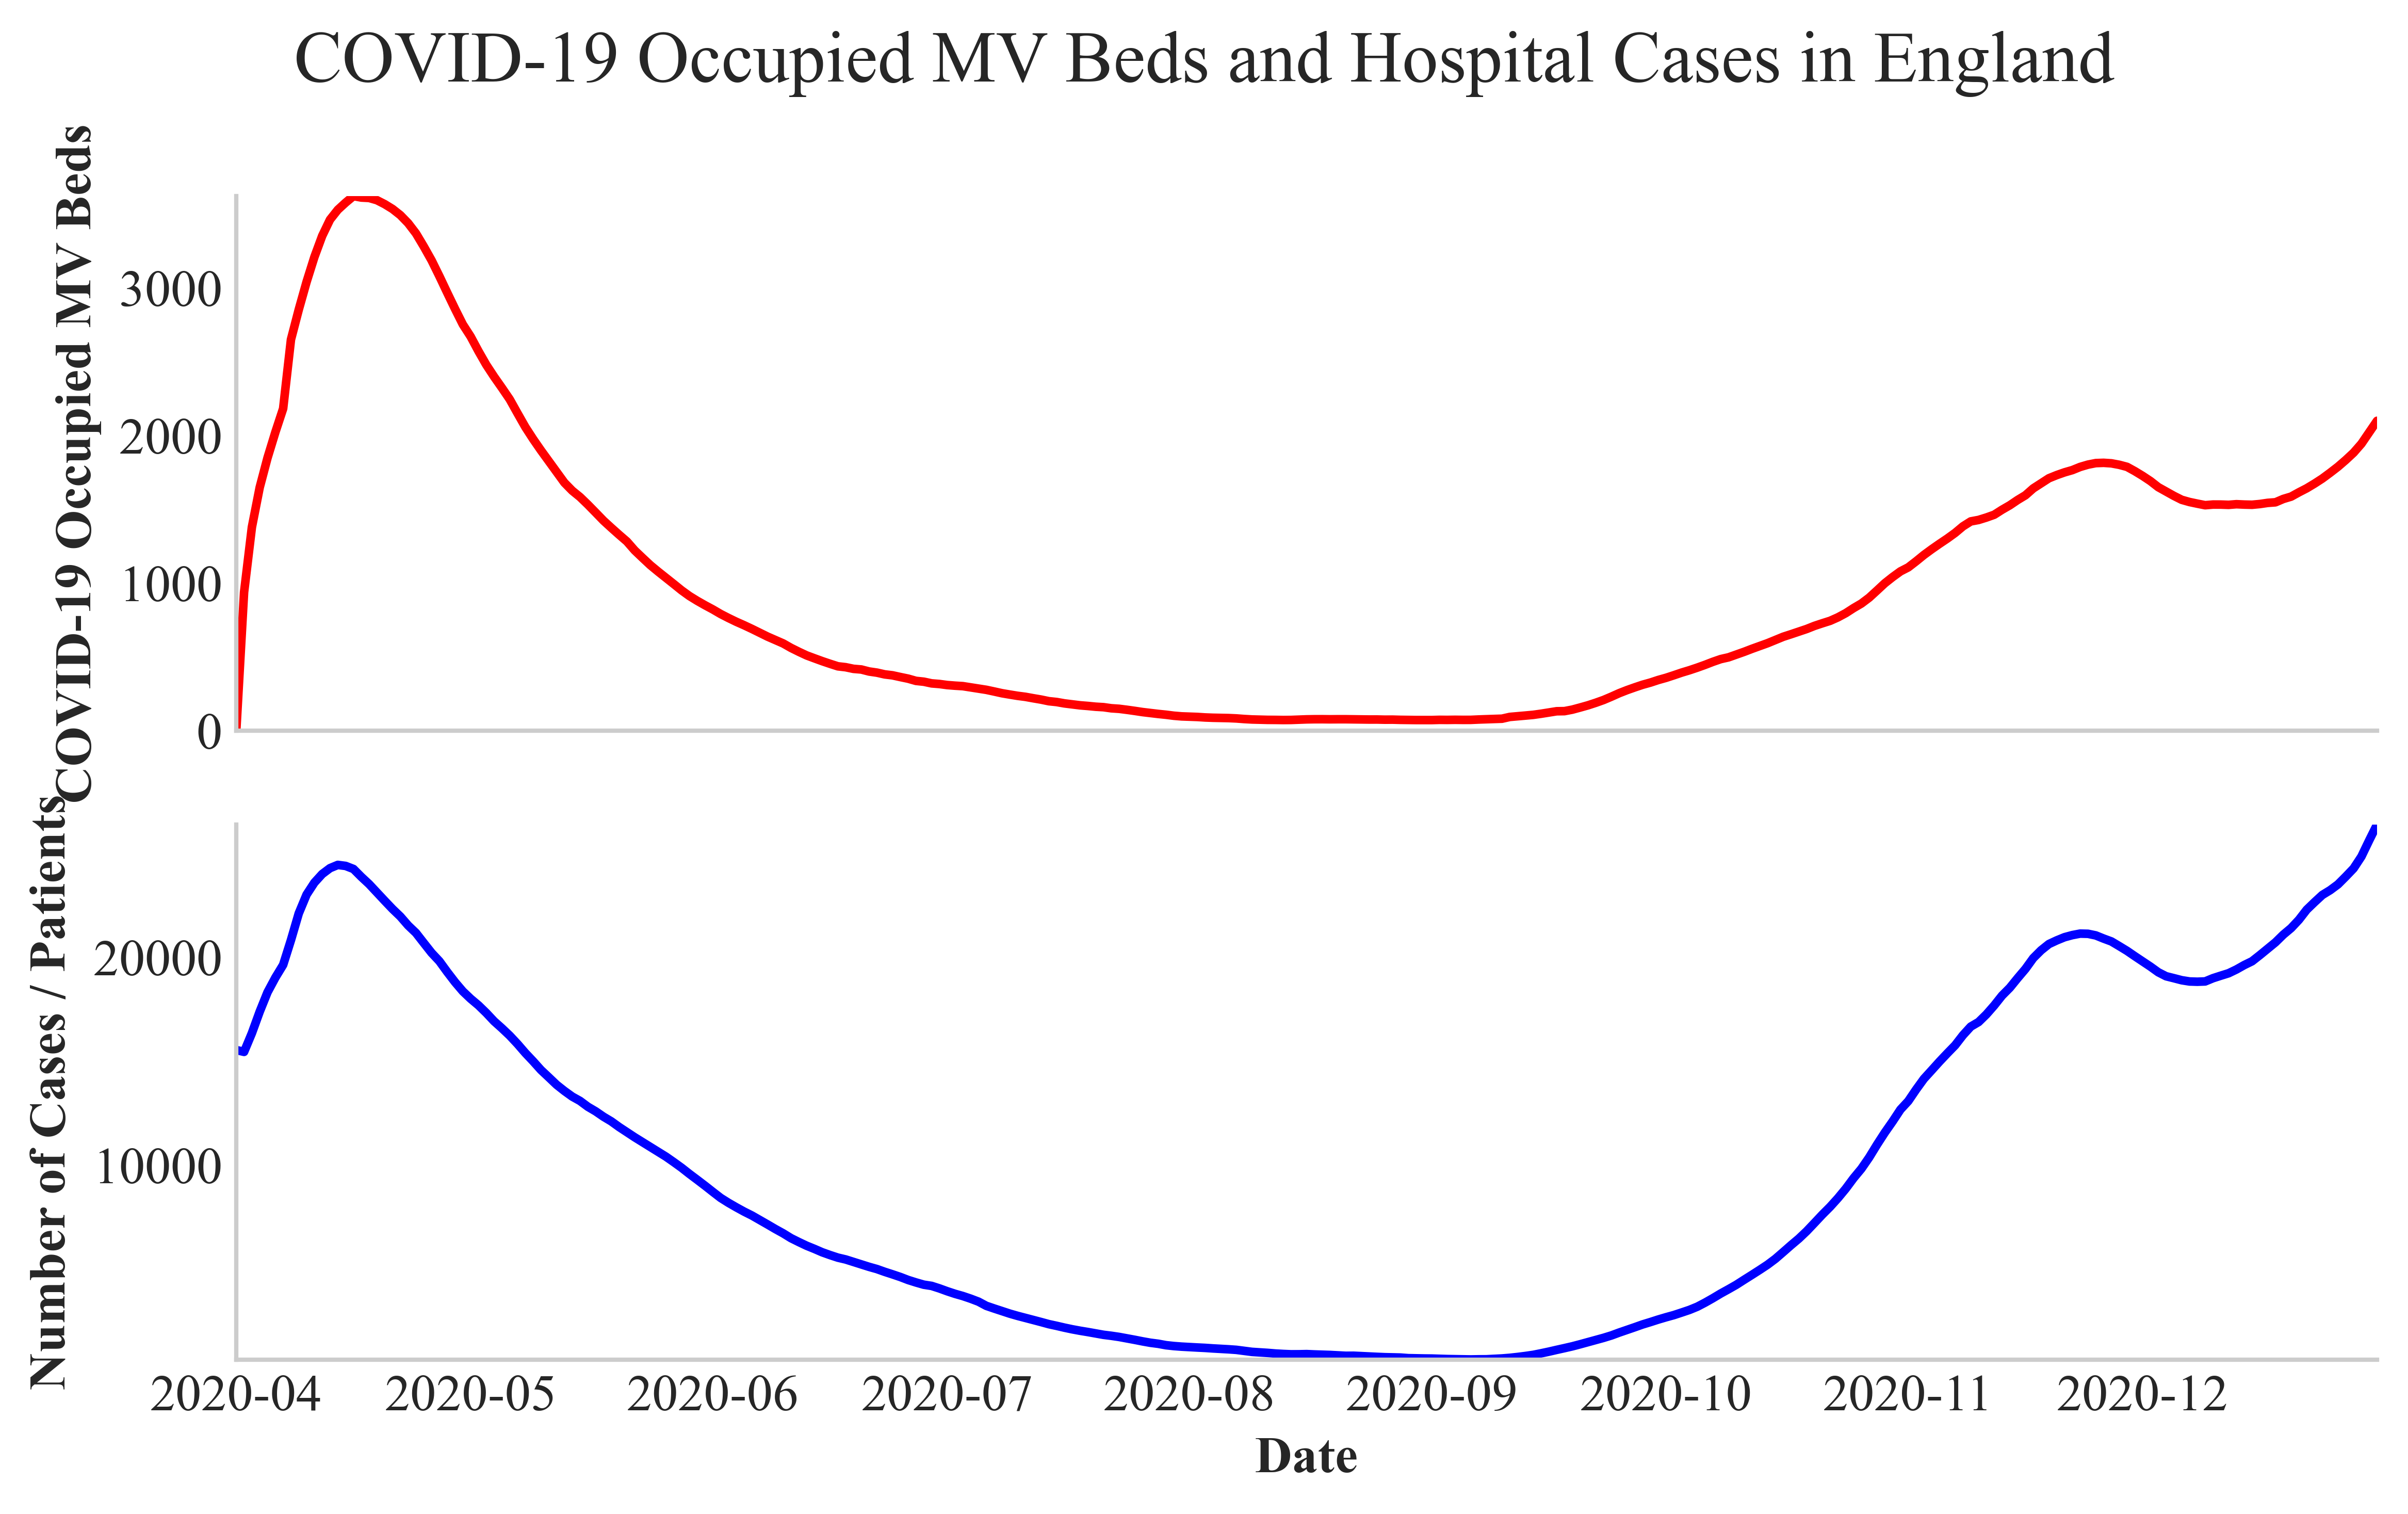

In [9]:
# visualize covidOccupiedMVBeds and hospitalCases on separate subplots sharing x-axis
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# Plotting COVID-19 Occupied MV Beds
ax[0].plot(data["date"], data["covidOccupiedMVBeds"], color="red")
ax[0].set_ylabel("COVID-19 Occupied MV Beds")

# Plotting Hospital Cases
ax[1].plot(data["date"], data["hospitalCases"], color="blue")
ax[1].set_ylabel("Hospital Cases")

# Setting a common x-label
plt.xlabel("Date")
plt.ylabel("Number of Cases / Patients")

# Adding a super title for the figure
plt.suptitle("COVID-19 Occupied MV Beds and Hospital Cases in England")

# Adjust the layout to make room for the shared legend
plt.tight_layout()  # Adjust the rect to leave space for the legend
# rect=[0, 0, 1, 0.95]
# Create a single legend for the whole figure in the top left corner
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.9, 0.9))

# Save the figure
plt.savefig("reports/figures/england_covid_occupied_mv_beds_hospital_cases.pdf")

# Show the plot
plt.show()

In [10]:
# Split the data into training, validation, and test sets and scale the training data
# train_data, val_data, test_data = split_time_series_data(
#     data, train_size=0.7, val_size=0.15, test_size=0.15
# )

scaler = MinMaxScaler()

In [11]:

def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    H = tensor(data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
    C = (
        tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, S, I, R, D, H, C


# Define the specific features used in the model
model_features = ['S(t)', 'active_cases', 'hospitalCases', 'covidOccupiedMVBeds', 'recovered', 'new_deceased']

# Fit the scaler only to these model features
scaler.fit(data[model_features])

# Transform the training, validation, and test data
data_scaled = pd.DataFrame(scaler.transform(data[model_features]), columns=model_features, index=data.index)
# test_data_scaled = pd.DataFrame(scaler.transform(test_data[model_features]), columns=model_features, index=test_data.index)
# val_data_scaled = pd.DataFrame(scaler.transform(val_data[model_features]), columns=model_features, index=val_data.index)
# test_data_scaled = pd.DataFrame(scaler.transform(test_data[model_features]), columns=model_features, index=test_data.index)

# Prepare tensors for each dataset using the updated scaled data
t_data, S_data, I_data, R_data, D_data, H_data, C_data  = prepare_tensors(data_scaled, device)
# t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(test_data_scaled, device)
# t_val, S_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(val_data_scaled, device)
# t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(test_data_scaled, device)

# Concatenate the tensors for each set
SIHCRD_tensor = torch.cat((S_data, I_data, H_data, C_data, R_data, D_data), dim=1)
# SIHCRD_tensor_val = torch.cat((S_val, I_val, H_val, C_val, R_val, D_val), dim=1)
# SIHCRD_tensor_test = torch.cat((S_test, I_test, H_test, C_test, R_test, D_test), dim=1)


In [12]:
# def seihcrd_model(t, y, params):
#     S, E, I, H, C, R, D = y
#     N = params["N"]
#     dSdt = -(params["beta"] * I / N) * S
#     dEdt = (params["beta"] * I / N) * S - params["sigma"] * E
#     dIdt = params["sigma"] * E - (params["gamma"] + params["rho"] + params["delta"]) * I
#     dHdt = params["rho"] * I - (params["eta"] + params["kappa"]) * H
#     dCdt = params["eta"] * H - (params["mu"] + params["xi"]) * C
#     dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
#     dDdt = params["delta"] * I + params["xi"] * C
#     return [dSdt, dEdt, dIdt, dHdt, dCdt, dRdt, dDdt]

# def sihcrd_model(t, y, params):
#     S, I, H, C, R, D = y
#     N = params["N"]
#     beta = params["beta"]
#     gamma = 0.125
#     rho = 0.03
#     delta = 0.02
#     eta = 0.125
#     kappa = 0.01875
#     mu = 0.14
#     xi = 0.143

#     S = N - sum(y)  # Recompute S based on other compartments
#     dSdt = -(beta * I / N) * S
#     dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
#     dHdt = rho * I - (eta + kappa) * H
#     dCdt = eta * H - (mu + xi) * C
#     dRdt = gamma * I + mu * C
#     dDdt = delta * I + xi * C
#     return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


In [13]:
# Define the neural network model with parameters estimation for the SIHCRD model
class SIHCRDNet(nn.Module):
    def __init__(
        self,
        init_beta=None,
        init_mu=None,
        init_delta=None,
        init_xi=None,
        retrain_seed=42,
        num_layers=4,
        hidden_neurons=10,
    ):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)

        # # Fixed parameters
        # self.gamma = 0.125  # Recovery rate
        # self.rho = 0.03  # Hospitalization rate
        # self.eta = 0.125  # Transition to critical state
        # self.kappa = 0.01875  # Recovery rate

        # Time varying learnable parameters
        self.beta = nn.Parameter(
            torch.tensor(
                [init_beta if init_beta is not None else torch.rand(1)], device=device
            ),
            requires_grad=True,
        )
        self.mu = nn.Parameter(
            torch.tensor(
                [init_mu if init_mu is not None else torch.rand(1)], device=device
            ),
            requires_grad=True,
        )
        self.delta = nn.Parameter(
            torch.tensor(
                [init_delta if init_delta is not None else torch.rand(1)], device=device
            ),
            requires_grad=True,
        )
        self.xi = nn.Parameter(
            torch.tensor(
                [init_xi if init_xi is not None else torch.rand(1)], device=device
            ),
            requires_grad=True,
        )

        # Initialize the network weights
        self.init_xavier()

    def forward(self, t):
        return torch.sigmoid(self.net(t))

    @property
    def beta(self):
        return torch.sigmoid(self._beta)

    @property
    def mu(self):
        return torch.sigmoid(self._mu)

    @property
    def delta(self):
        return torch.sigmoid(self._delta)

    @property
    def xi(self):
        return torch.sigmoid(self._xi)

    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0.001)

        self.apply(init_weights)

In [14]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SIHCRD_tensor,
    t_data,
    N,
    beta=None,
    mu=None,
    delta=None,
    xi=None, 
    index=None
):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor[:, 0], SIHCRD_tensor[:, 1], SIHCRD_tensor[:, 2], SIHCRD_tensor[:, 3], SIHCRD_tensor[:, 4], SIHCRD_tensor[:, 5]
    
    #derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_data, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_data, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_data, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_data, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_data, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_data, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # fixed parameters
    gamma = 0.125
    rho = 0.03
    eta = 0.125
    kappa = 0.01875
    
    N = N / N # Normalize the population size
    
    # Time varying parameters 
    beta = model.beta
    mu = model.mu
    delta = model.delta
    xi = model.xi
    
    
    # SIHCRD model equations
    dSdt = -(beta * I_pred / N) * S_pred
    dIdt = (beta * S_pred / N) * I_pred - (gamma + rho + delta) * I_pred
    dHdt = rho * I_pred - (eta + kappa) * H_pred
    dCdt = eta * H_pred - (mu + xi) * C_pred
    dRdt = gamma * I_pred + mu * C_pred
    dDdt = delta * I_pred + xi * C_pred
    
    
    # physical informed loss
    loss = nn.MSELoss()(S_t, dSdt) + nn.MSELoss()(I_t, dIdt) + nn.MSELoss()(H_t, dHdt) + nn.MSELoss()(C_t, dCdt) + nn.MSELoss()(R_t, dRdt) + nn.MSELoss()(D_t, dDdt)
    
    # data fitting loss
    loss += nn.MSELoss()(S_pred[index], S_true[index]) + nn.MSELoss()(I_pred[index], I_true[index]) + nn.MSELoss()(H_pred[index], H_true[index]) + nn.MSELoss()(C_pred[index], C_true[index]) + nn.MSELoss()(R_pred[index], R_true[index]) + nn.MSELoss()(D_pred[index], D_true[index])
    
    # initial conditions loss
    loss += nn.MSELoss()(S_pred[0], S_true[0]) + nn.MSELoss()(I_pred[0], I_true[0]) + nn.MSELoss()(H_pred[0], H_true[0]) + nn.MSELoss()(C_pred[0], C_true[0]) + nn.MSELoss()(R_pred[0], R_true[0]) + nn.MSELoss()(D_pred[0], D_true[0])
    return loss 


In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


In [18]:
def train_sihcrd_model(
    model,
    t_data,    
    SIHCRD_tensor,
    epoch=1000, 
    lr=1e-1,
    N=None,
    beta=None,
    mu=None,
    delta=None,
    xi=None,
    patience=5,
    verbose=True
):
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adamax optimizer
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
    scheduler = StepLR(optimizer, step_size=10000, gamma=0.90)
    
    # Initialize the early stopping callback
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    losses = []
    
    for i in tqdm(range(epoch)):
        # Set the model to training mode
        model.train()
        
        # Zero the gradients0
        optimizer.zero_grad()
        
        # Forward pass
        model_output = model(t_data)
        
        index = torch.randperm(train_size)
        
        # Compute the loss
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor, t_data, N, beta, mu, delta, xi, index=index)
        
        # Backward pass
        loss.backward()
        
        # Optimize the model parameters
        optimizer.step()
        
        # Record the loss
        losses.append(loss.item())
        
        # Reduce the learning rate
        scheduler.step()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch {i + 1}/{epoch} Loss: {loss.item()}")
        
        # Early stopping
        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")
            print("Training completed.")
            break
        
            
        
    return losses 


In [19]:
model = SIHCRDNet(init_beta=0.1, init_mu=0.01, init_delta=0.01, init_xi=0.005, num_layers=6, hidden_neurons=32).to(device)  

losses = train_sihcrd_model(
    model,
    t_data,
    SIHCRD_tensor,
    epoch=50000,
    lr=3e-4,
    N=params["N"],
    patience=100,
    verbose=False
)       

  0%|          | 0/50000 [00:00<?, ?it/s]

c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([275])) that is different to the input size (torch.Size([275, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/50000 Loss: 0.19312091171741486
Epoch 200/50000 Loss: 0.10910475254058838
Epoch 300/50000 Loss: 0.022815614938735962
Epoch 400/50000 Loss: 0.015683770179748535
Epoch 500/50000 Loss: 0.013261241838335991
Epoch 600/50000 Loss: 0.011628102511167526
Epoch 700/50000 Loss: 0.010293508879840374
Epoch 800/50000 Loss: 0.009204398840665817


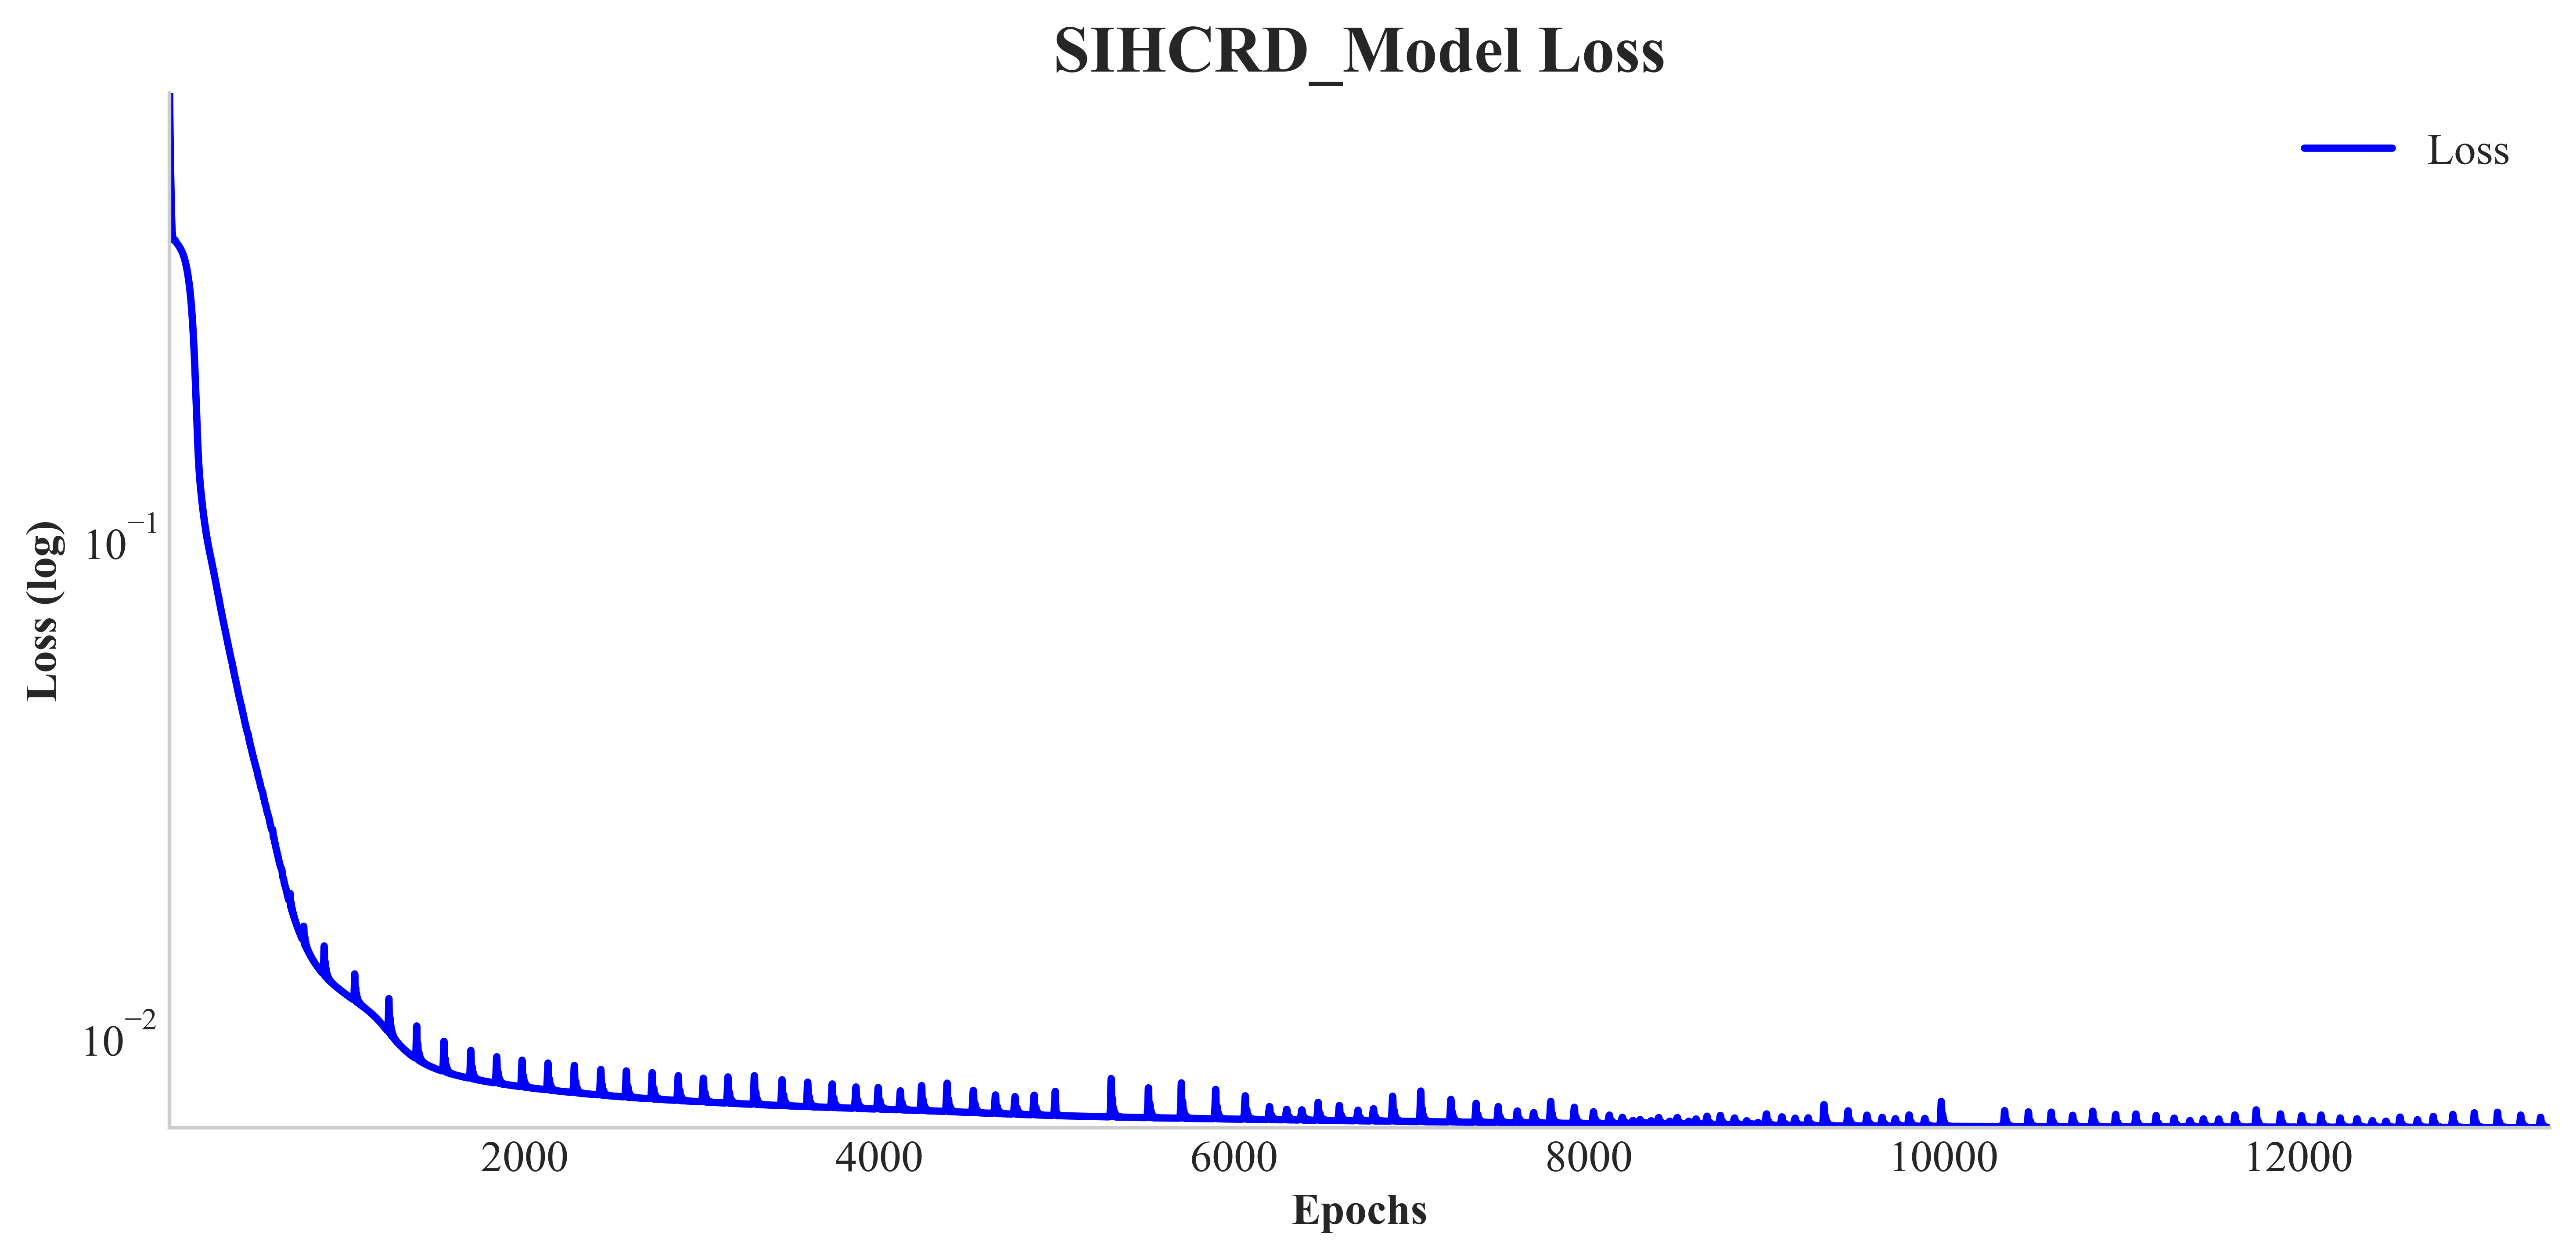

In [ ]:
def plot_loss(
    losses,
    title,
    save_path="reports/figures",
    show=True,
    figsize=(10, 5),
    grid=True,
    save_format="pdf",
):
    """
    Enhanced plotting function for the training loss of a model, with logarithmic y-axis.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (8, 5).
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """
    
    # Logarithmic y-axis scale for the loss10 plot starting from epoch 1 (not 0) for better visualization and the x-axis starts from 0
    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
    plt.yscale("log")
    plt.title(f"{title} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (log)")
    plt.legend()
    # plt.grid(grid)

    
    if save_path:
        plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss_of_PINNs_log.{save_format}")
    if show:
        plt.show()
        
plot_loss(losses, "SIHCRD_Model")

In [ ]:
# import matplotlib.dates as mdates


# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     predictions = model(t_data).cpu()
    
    
# # Extract predictions into individual components
# S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5]

# # Extract true values from the tensor
# S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor[:, 0], SIHCRD_tensor[:, 1], SIHCRD_tensor[:, 2], SIHCRD_tensor[:, 3], SIHCRD_tensor[:, 4], SIHCRD_tensor[:, 5]

NameError: name 'model' is not defined

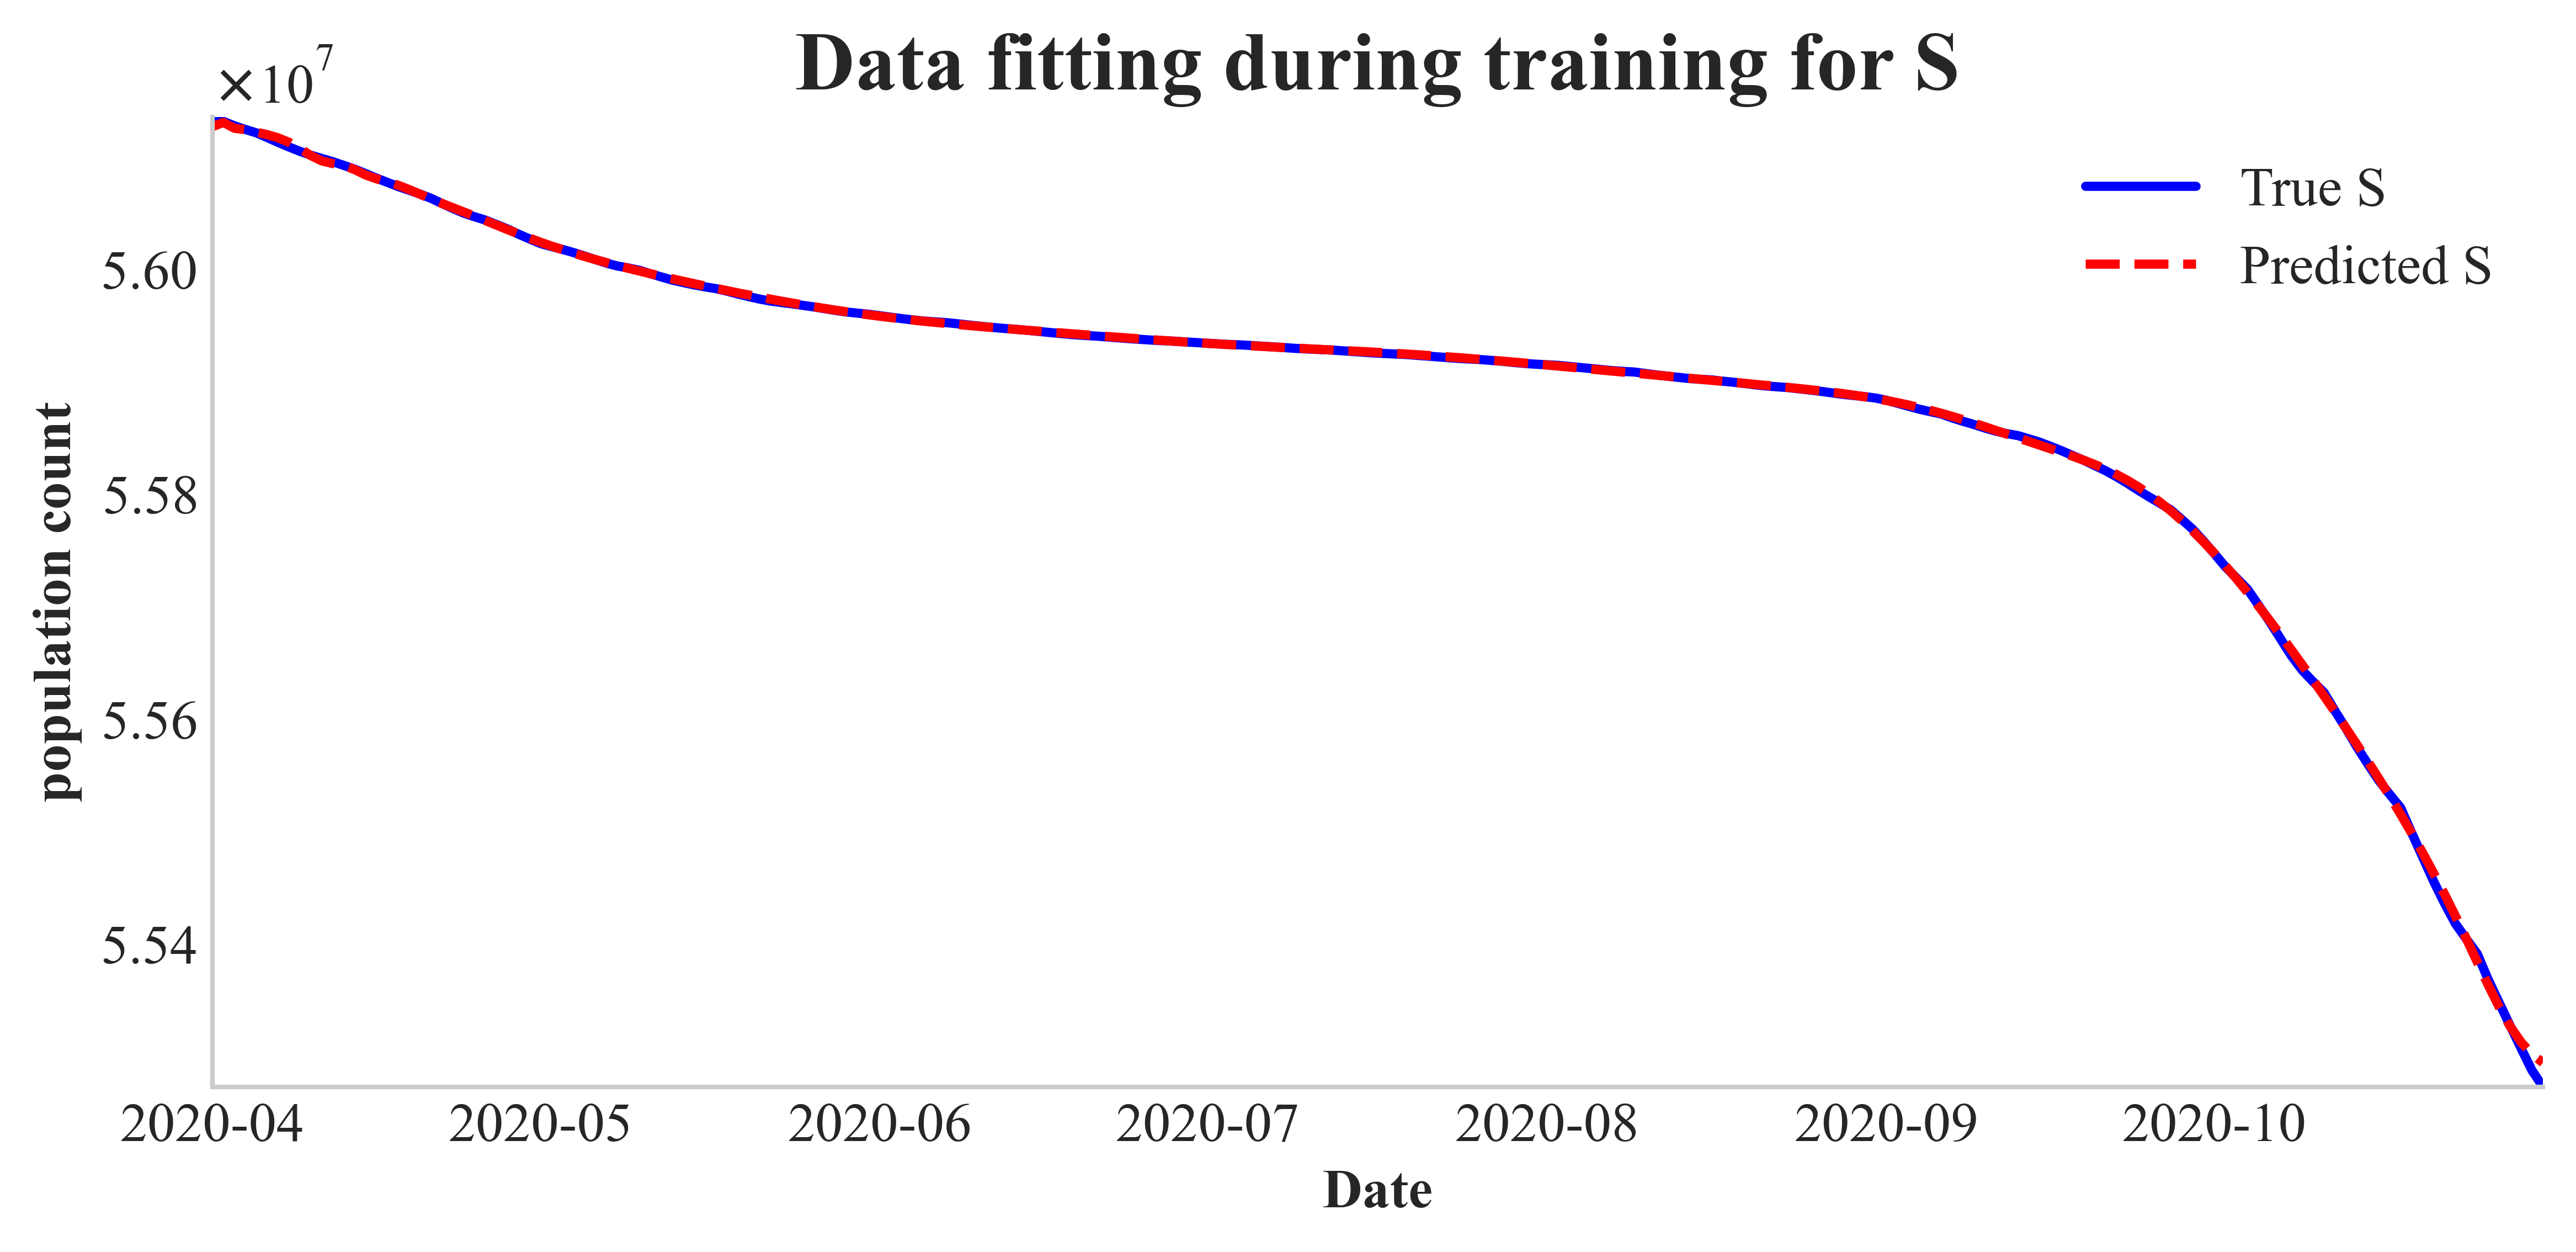

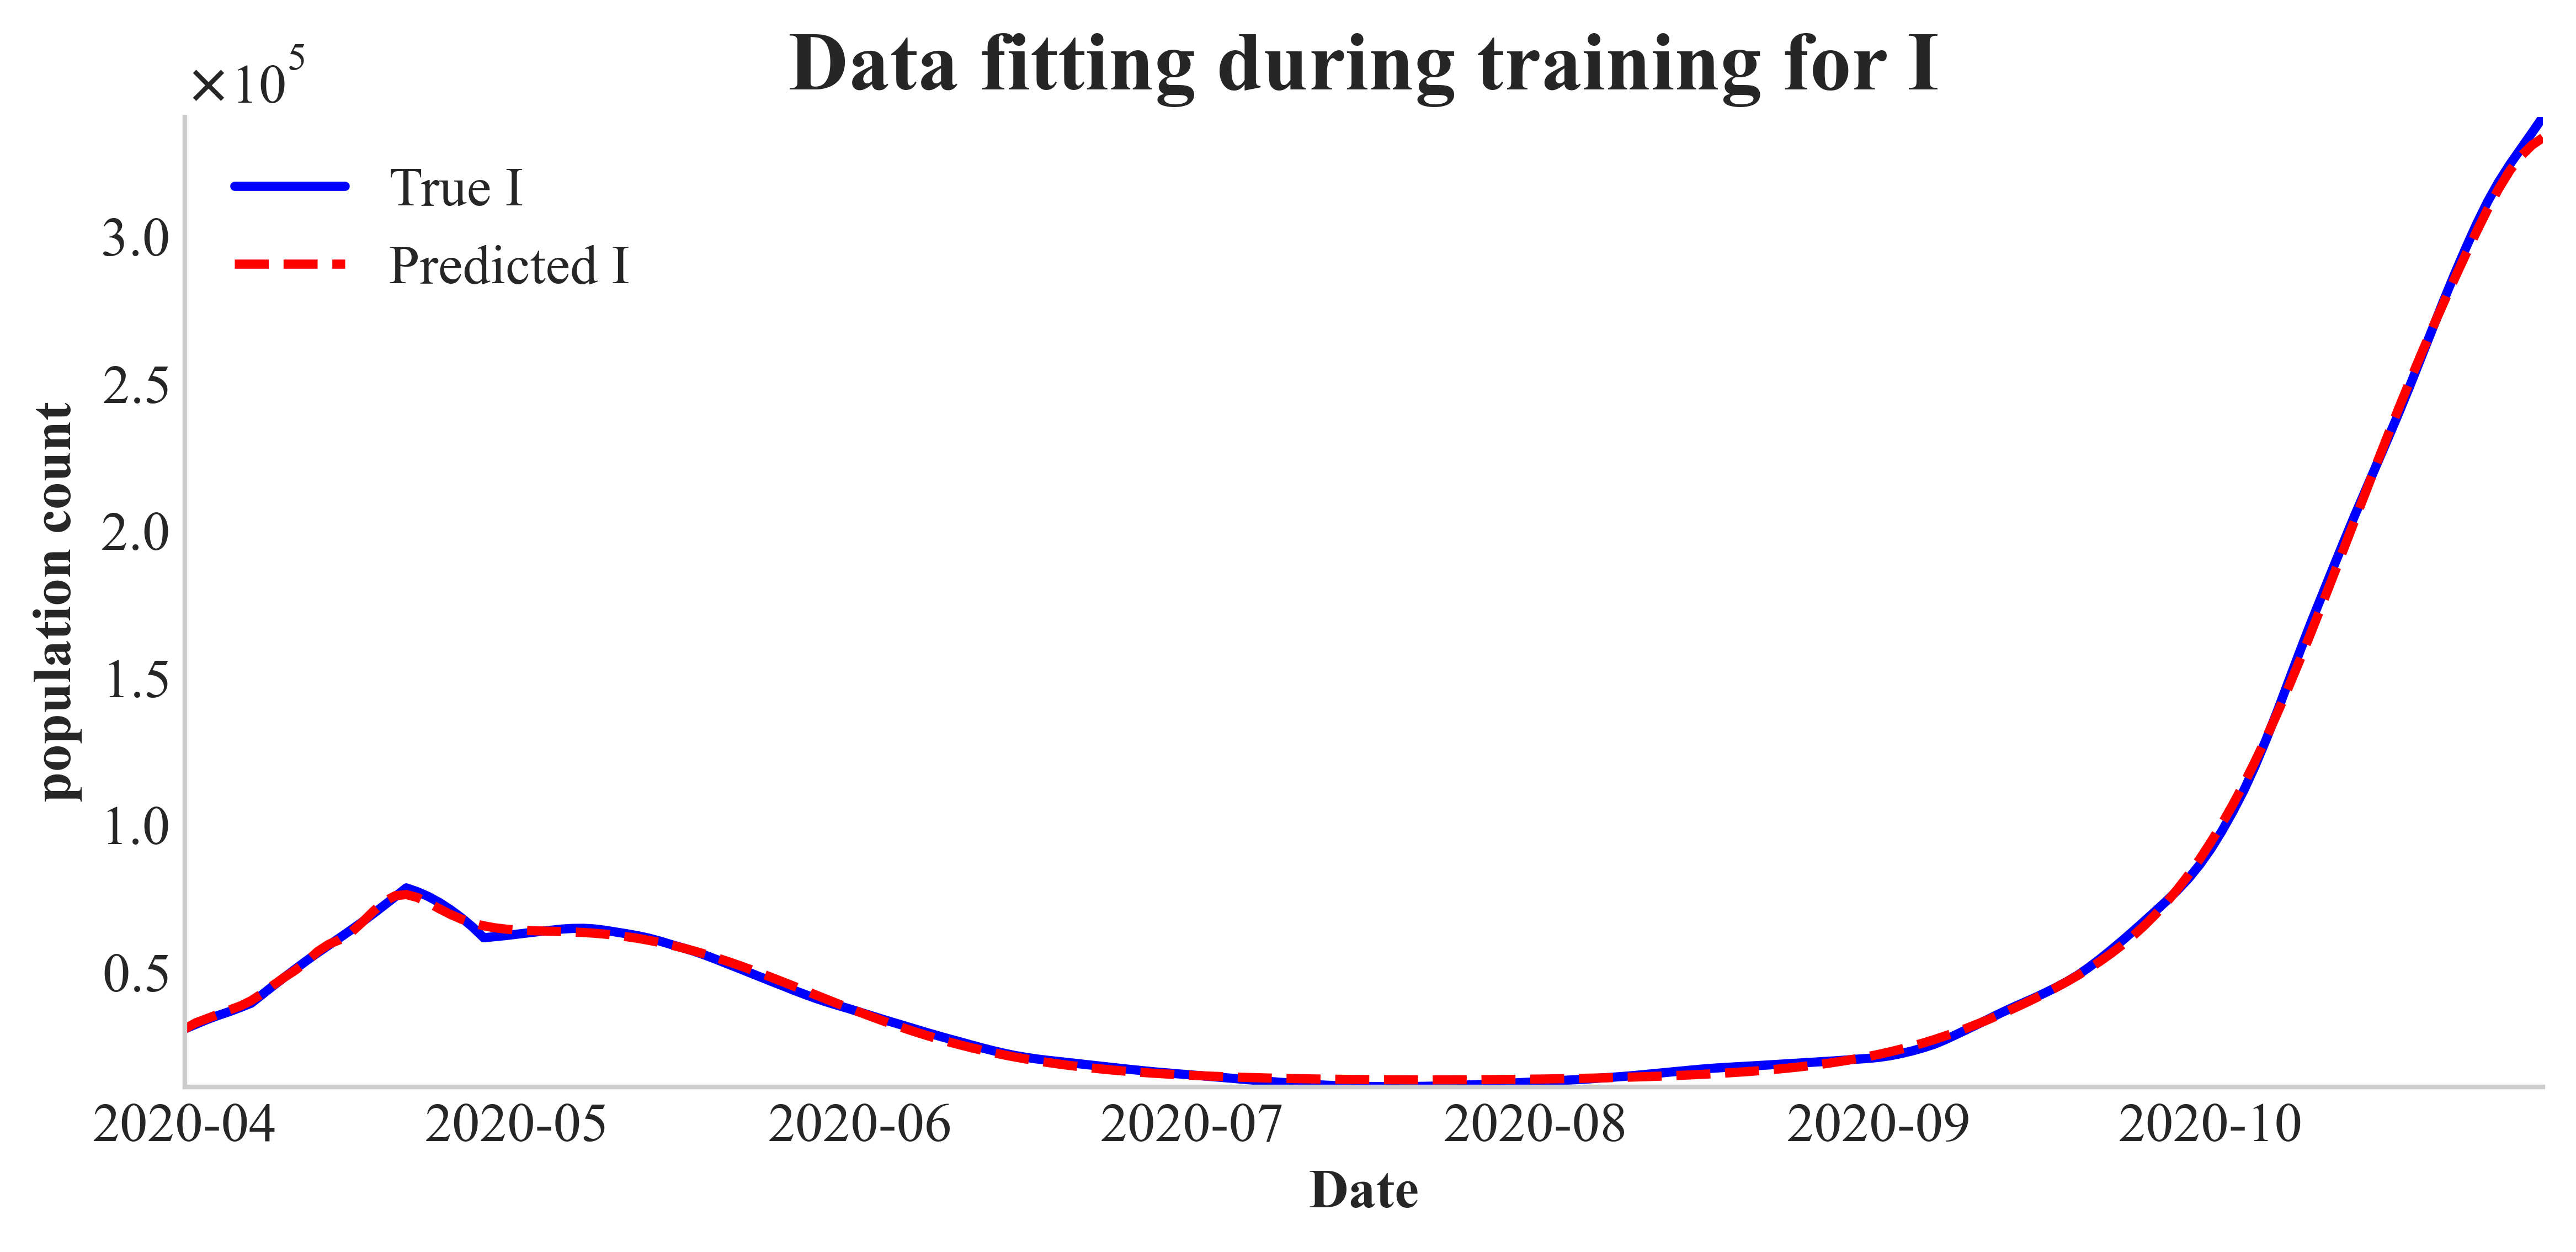

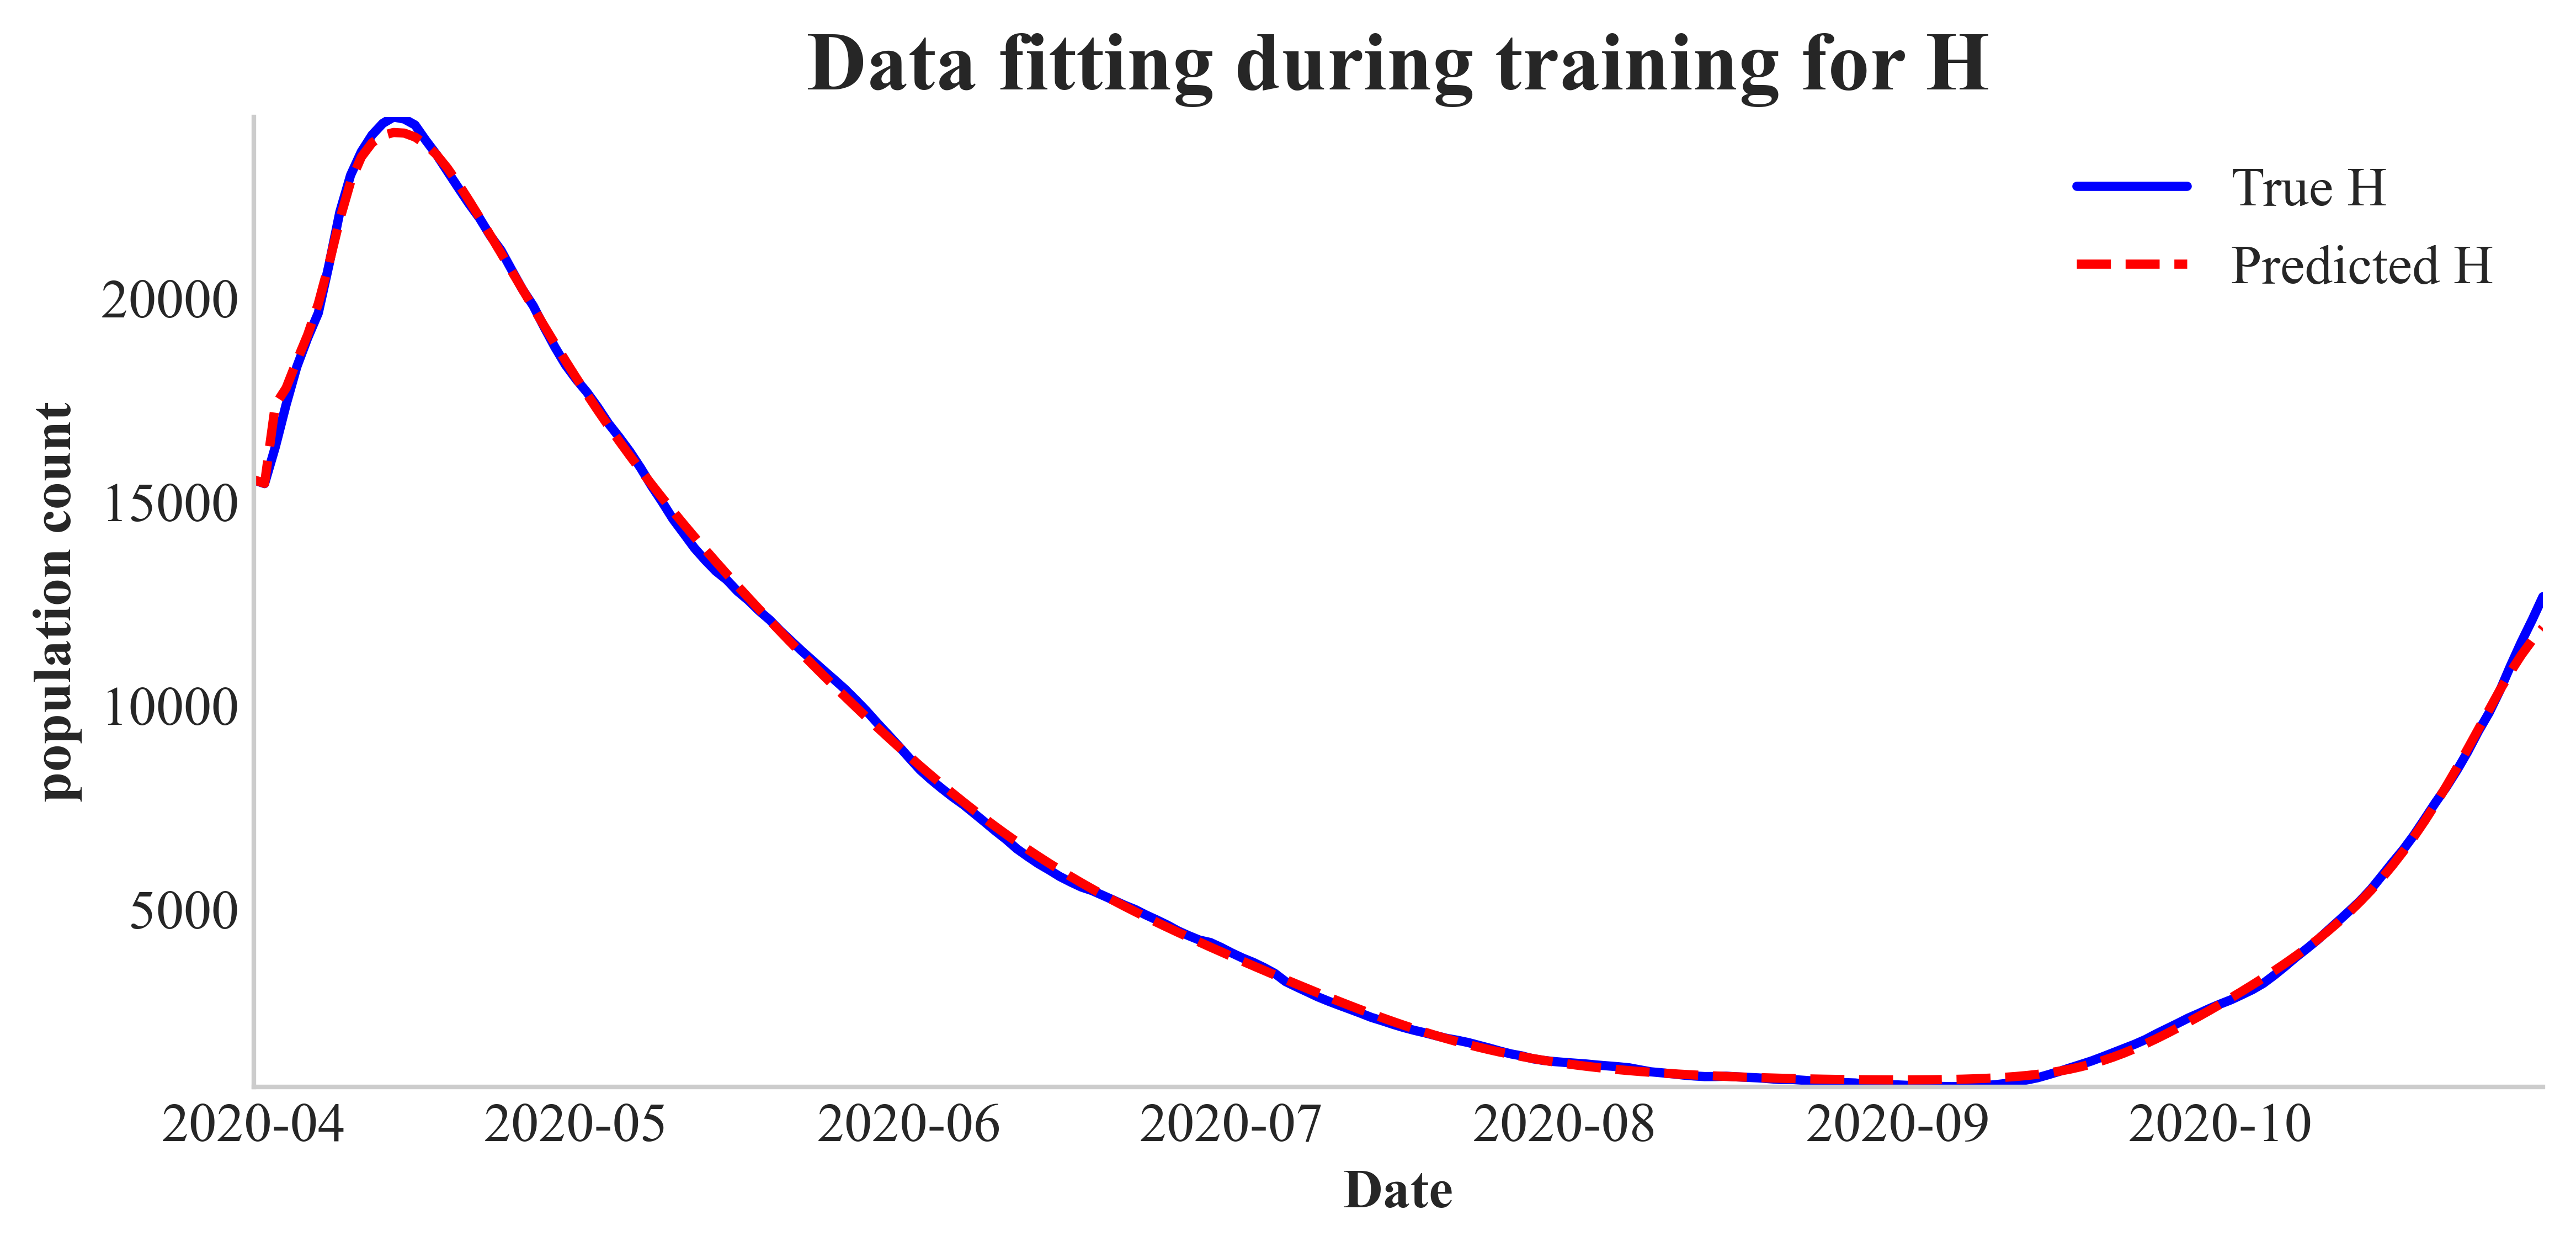

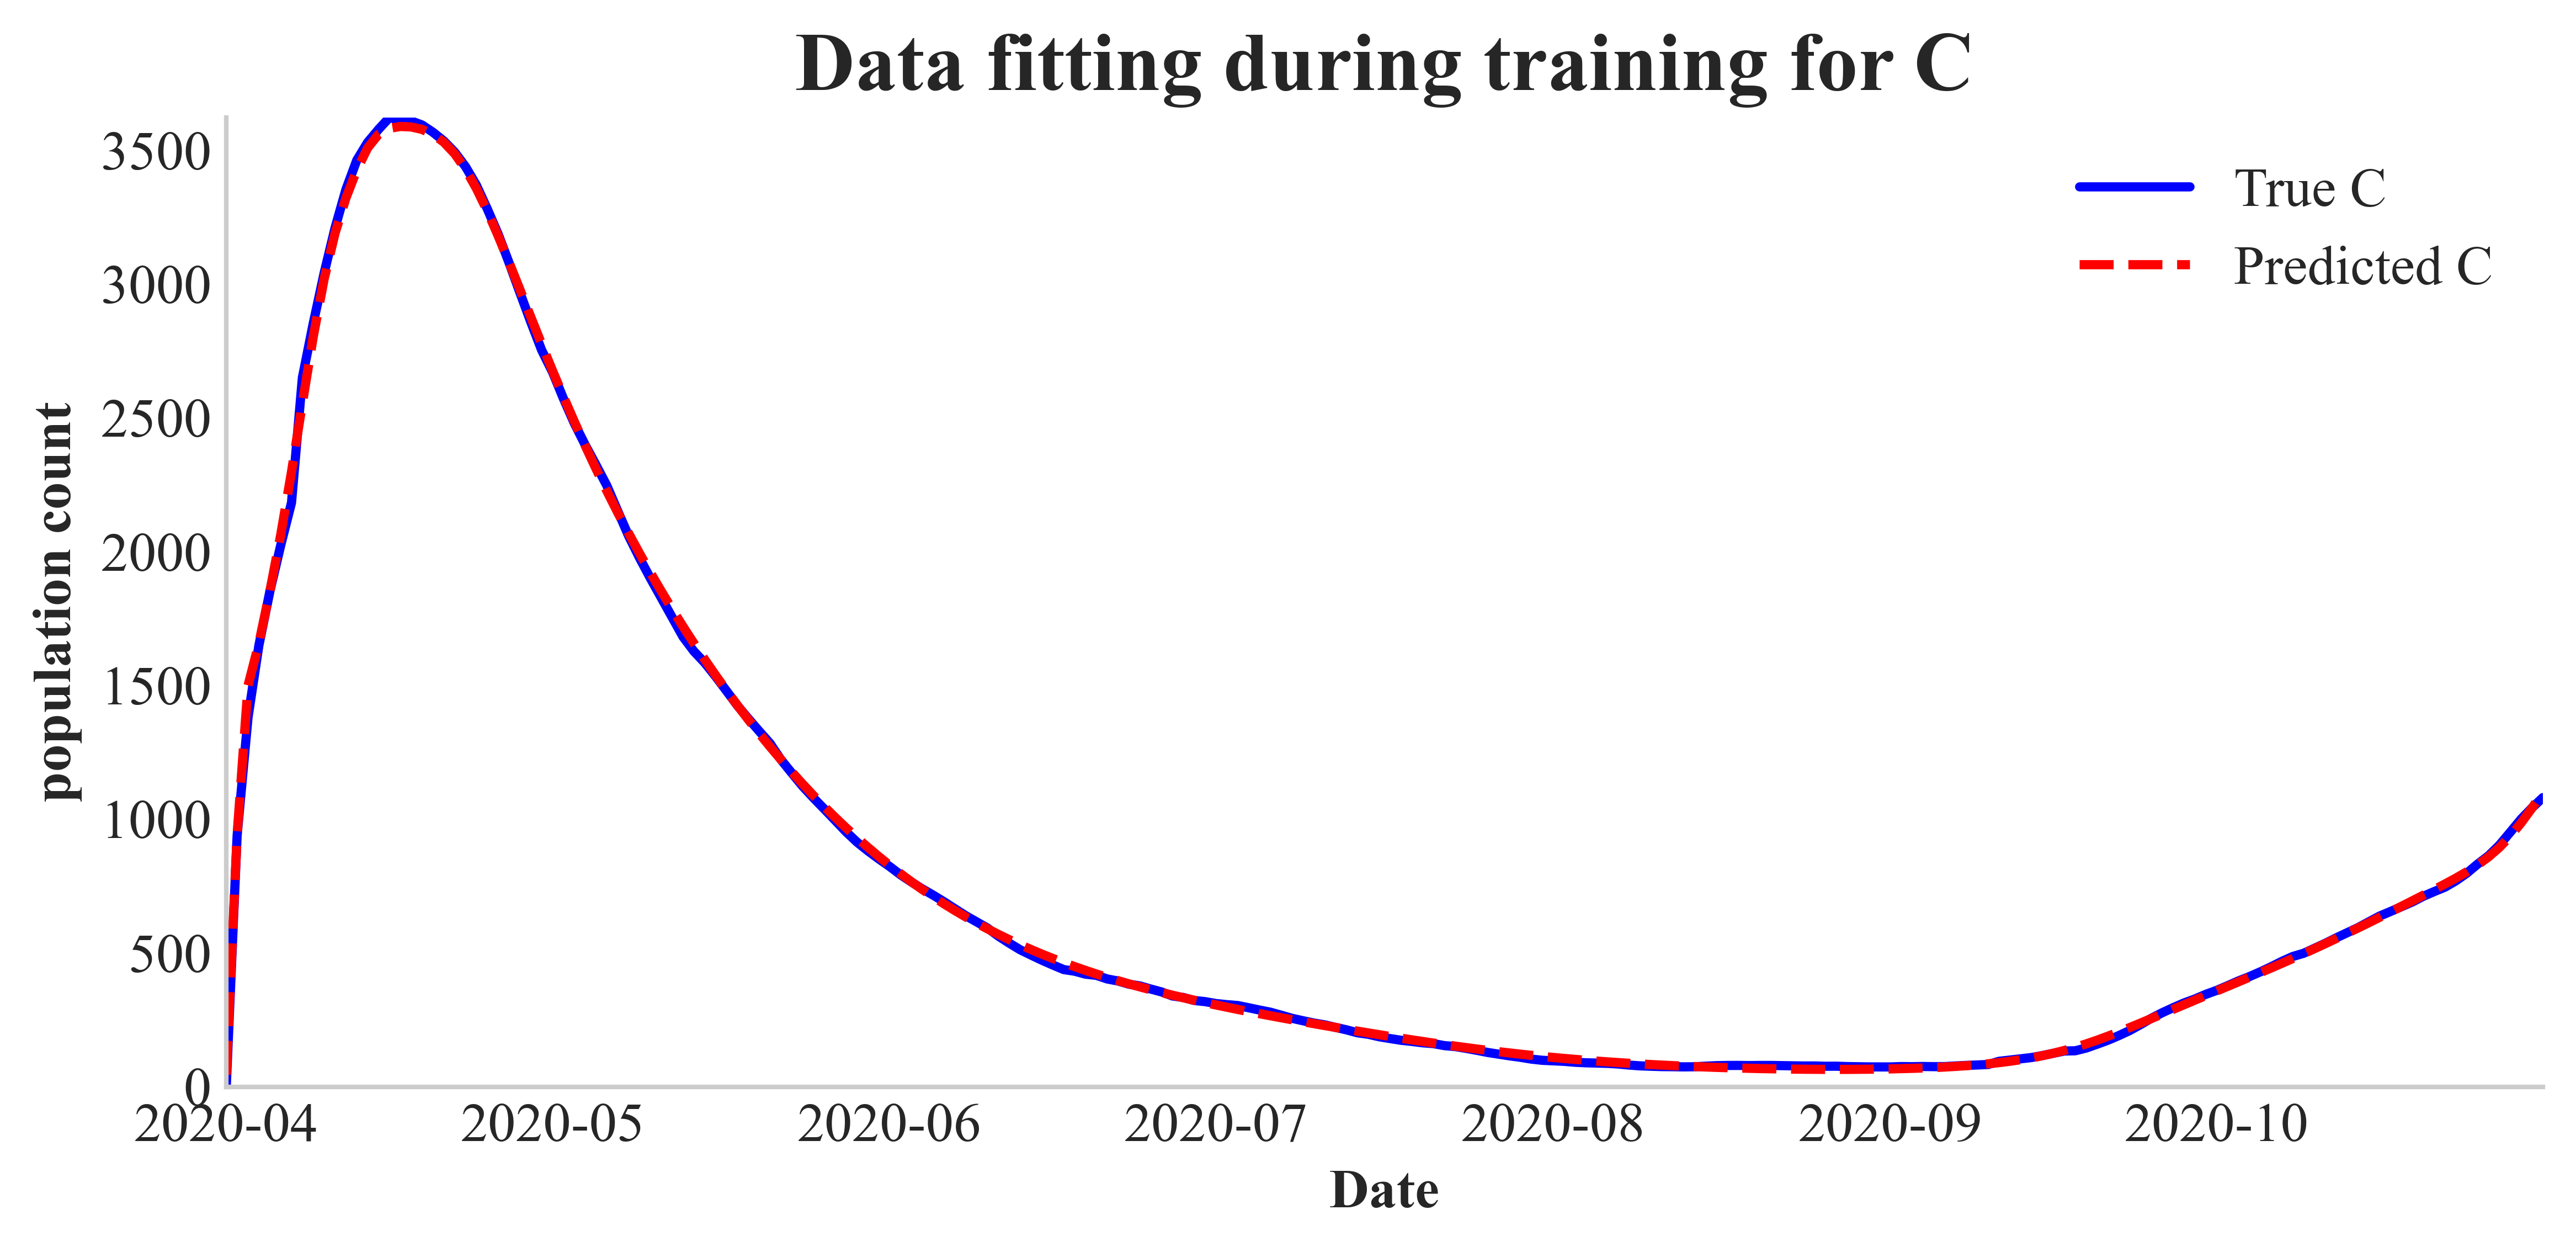

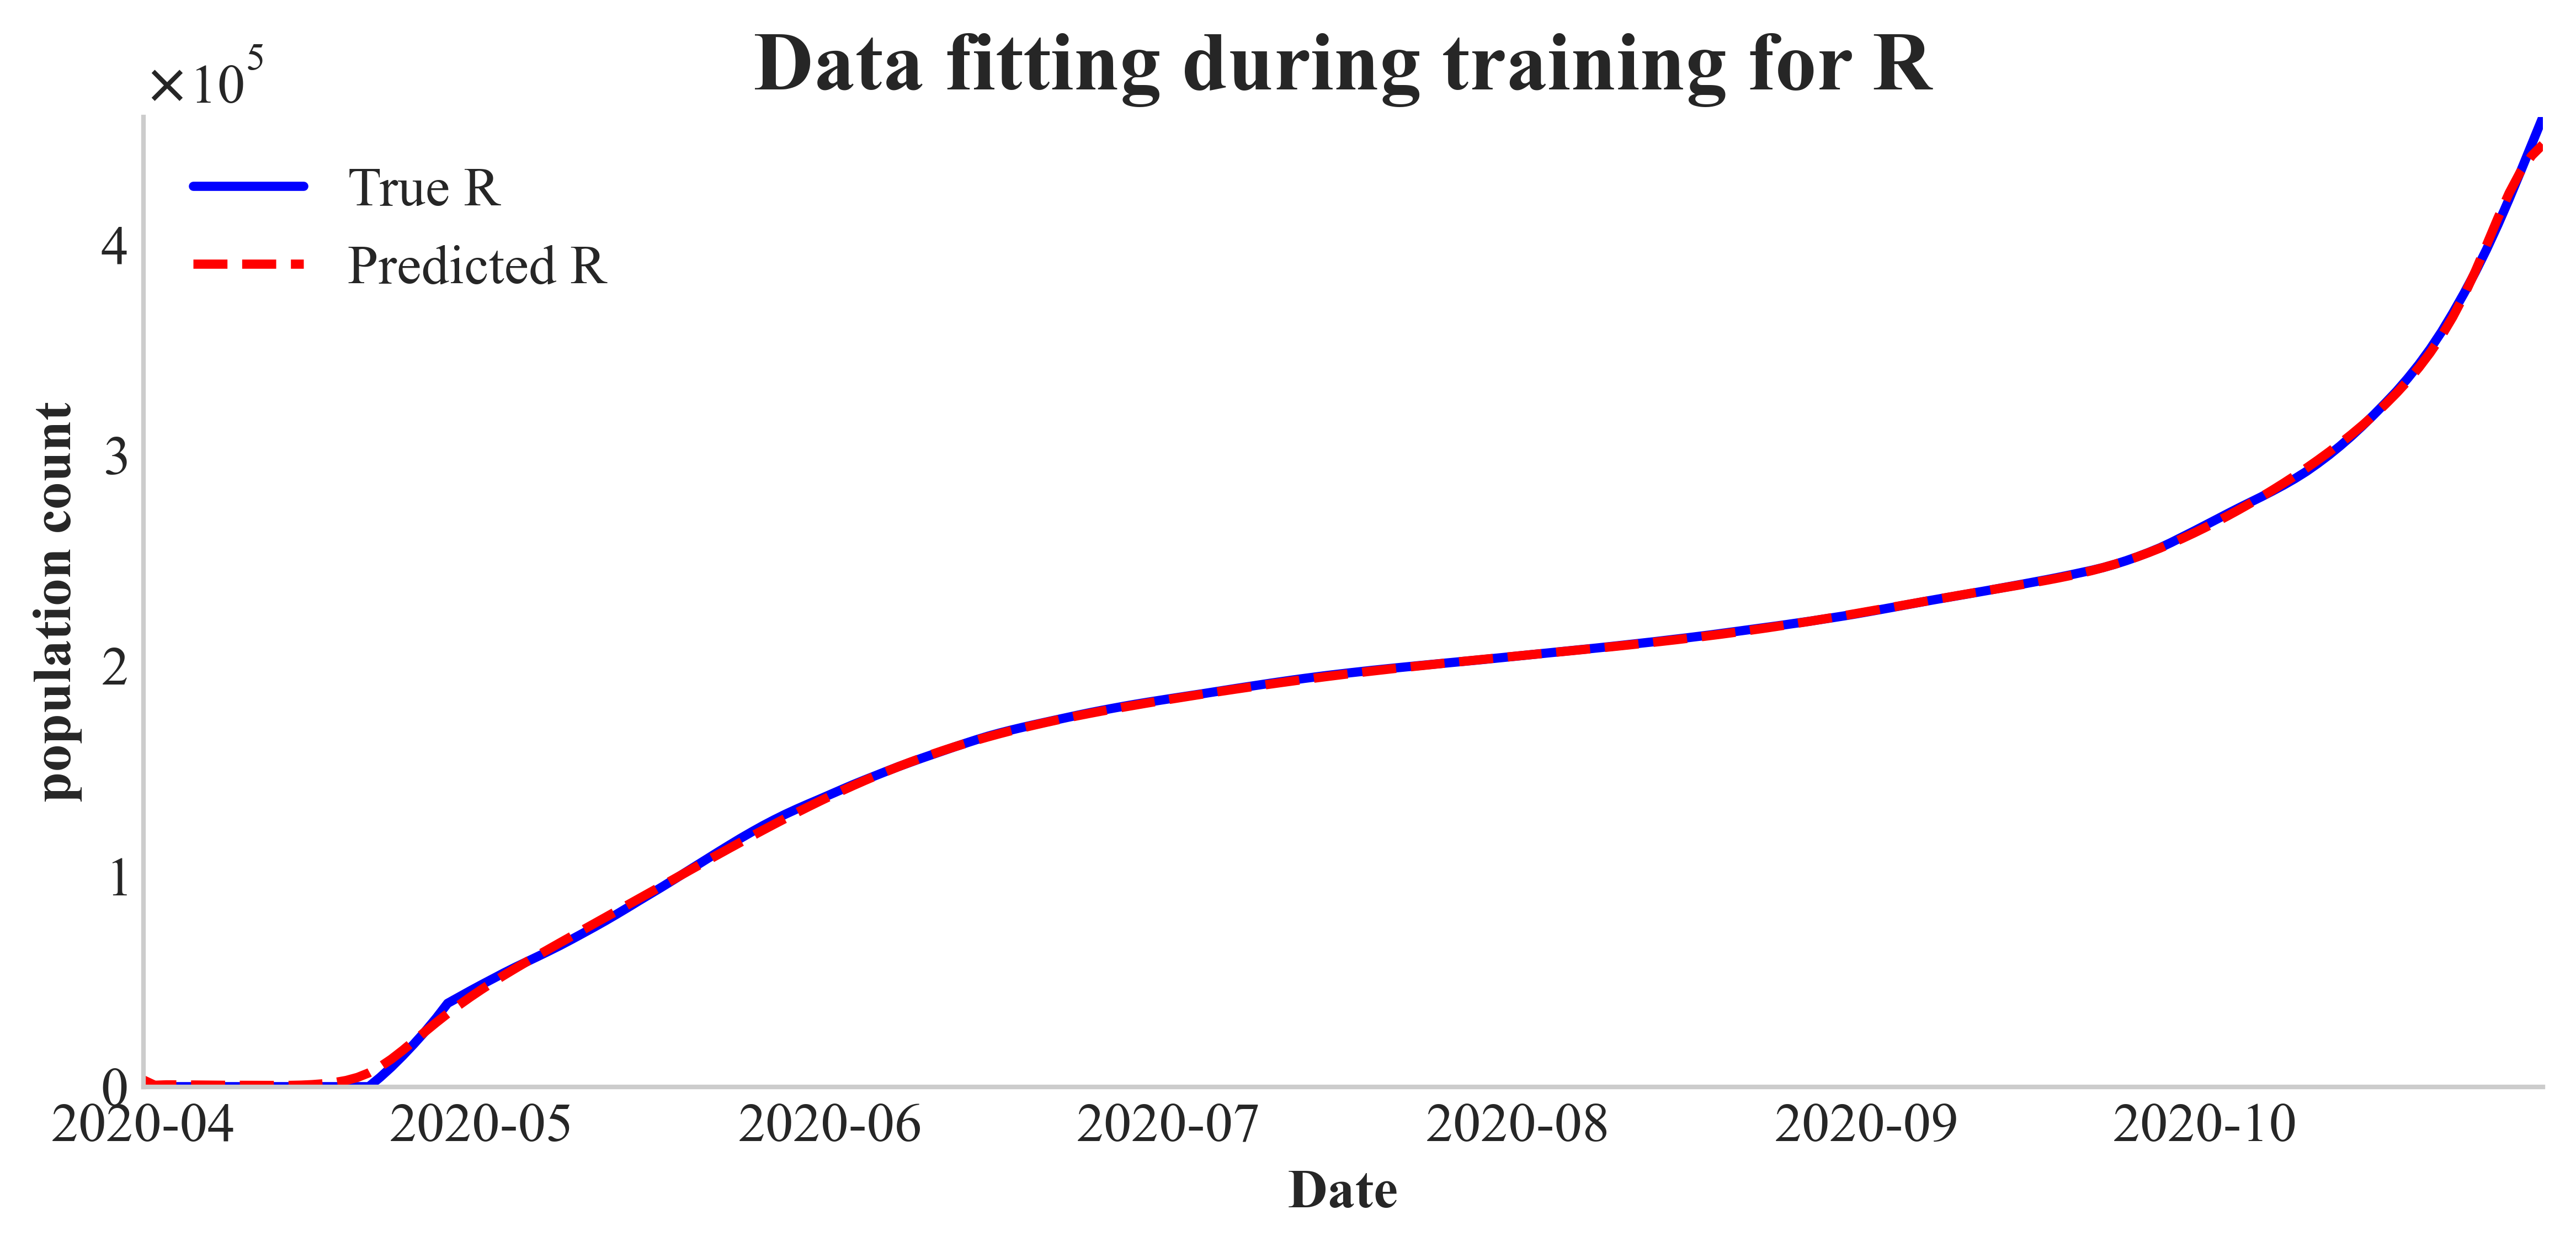

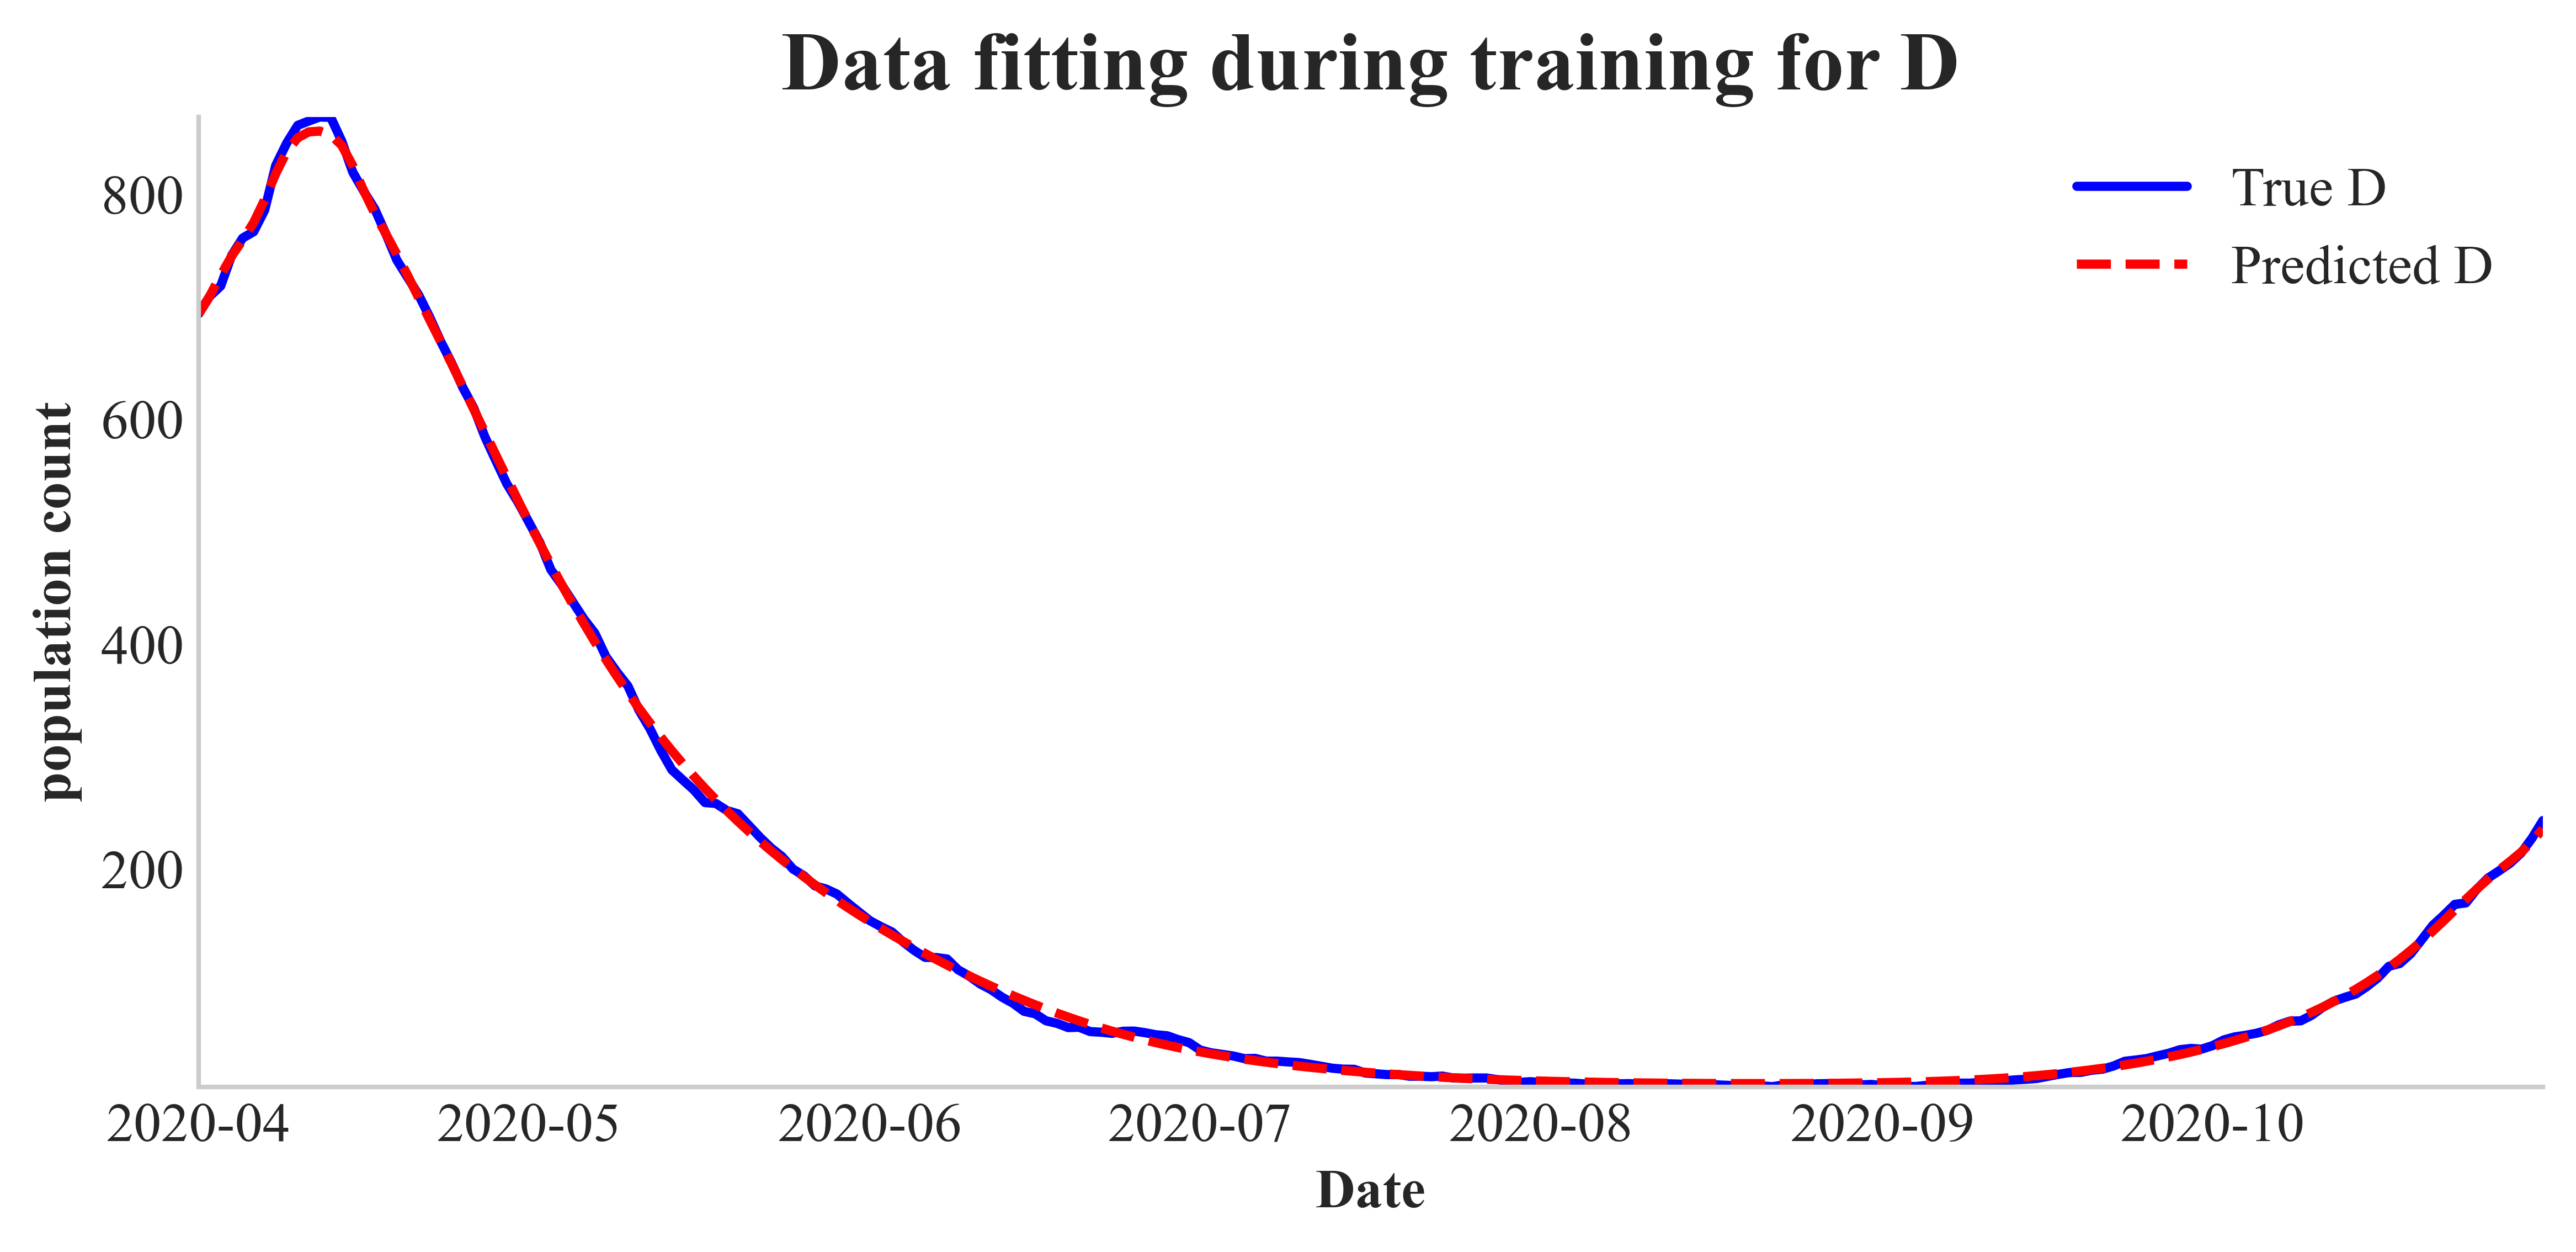

In [ ]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(t_data).cpu()  # Move tensors to CPU for plotting

# Extract predictions into individual components
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5]

# Extract true values from the tensor
S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor[:, 0], SIHCRD_tensor[:, 1], SIHCRD_tensor[:, 2], SIHCRD_tensor[:, 3], SIHCRD_tensor[:, 4], SIHCRD_tensor[:, 5]


# Ensure all tensors are on CPU before converting to NumPy arrays for scaling
S_pred = S_pred.cpu()
I_pred = I_pred.cpu()
H_pred = H_pred.cpu()
C_pred = C_pred.cpu()
R_pred = R_pred.cpu()
D_pred = D_pred.cpu()

S_true = S_true.cpu()
I_true = I_true.cpu()
H_true = H_true.cpu()
C_true = C_true.cpu()
R_true = R_true.cpu()
D_true = D_true.cpu()

# Prepare data for rescaling
rescaled_pred = scaler.inverse_transform(
    np.concatenate(
        [
            S_pred.view(-1, 1).numpy(),
            I_pred.view(-1, 1).numpy(),
            H_pred.view(-1, 1).numpy(),
            C_pred.view(-1, 1).numpy(),
            R_pred.view(-1, 1).numpy(),
            D_pred.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)

rescaled_true = scaler.inverse_transform(
    np.concatenate(
        [
            S_true.view(-1, 1).numpy(),
            I_true.view(-1, 1).numpy(),
            H_true.view(-1, 1).numpy(),
            C_true.view(-1, 1).numpy(),
            R_true.view(-1, 1).numpy(),
            D_true.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)


# Extract rescaled for all compartments and plot individual plots
S_pred_rescaled, I_pred_rescaled, H_pred_rescaled, C_pred_rescaled, R_pred_rescaled, D_pred_rescaled = rescaled_pred[:, 0], rescaled_pred[:, 1], rescaled_pred[:, 2], rescaled_pred[:, 3], rescaled_pred[:, 4], rescaled_pred[:, 5]

S_true_rescaled, I_true_rescaled, H_true_rescaled, C_true_rescaled, R_true_rescaled, D_true_rescaled = rescaled_true[:, 0], rescaled_true[:, 1], rescaled_true[:, 2], rescaled_true[:, 3], rescaled_true[:, 4], rescaled_true[:, 5]

# Plot the rescaled predictions and true values for each compartment on a different plot
# Generate plots for each component
for i, comp in enumerate(["S", "I", "H", "C", "R", "D"]):
    plt.figure(figsize=(8, 4))
    plt.plot(data["date"], rescaled_true[:, i], label=f"True {comp}", color="blue", linewidth=2)
    plt.plot(data["date"], rescaled_pred[:, i], label=f"Predicted {comp}", linestyle="--", color="red", linewidth=2)
    plt.title(f"Data fitting during training for {comp}")
    plt.xlabel("Date")
    plt.ylabel("population count")
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"reports/figures/SIHCRD_{comp}_Predicted_vs_True.pdf")
    plt.show()


In [ ]:
# Extract the parameters from the model for the SIHCRD model and print them
beta = model.beta.item()
mu = model.mu.item()
delta = model.delta.item()
xi = model.xi.item()

print(f"Estimated beta: {beta:.4f}")
print(f"Estimated mu: {mu:.4f}")
print(f"Estimated delta: {delta:.4f}")
print(f"Estimated xi: {xi:.4f}")

Estimated beta: 0.0945
Estimated mu: -0.0007
Estimated delta: -0.0977
Estimated xi: 0.0822
